In [1]:
import numpy as np
import matplotlib.pyplot as plt

import os
import h5py

In [2]:
runs_path = 'H:/Bachelorarbeit/Daten/runs/'
run_path = runs_path + 'run_1/'

step = 0

t = None
n = None
x = None
m = None

with h5py.File(run_path + 'snap.40_0.h5part') as f:
    t = f[f'Step#{step}']['000 Scalars'][0]
    n = np.array(f[f'Step#{step}']['032 Name'])
    x = np.array([f[f'Step#{step}']['001 X1'],f[f'Step#{step}']['002 X2'],f[f'Step#{step}']['003 X3']])
    m = np.array(f[f'Step#{step}']['023 M'])
    
    sort = np.argsort(n)
    n = n[sort]
    x = x[:,sort]
    m = m[sort]

In [3]:
t

0.0

In [4]:
x

array([[-1.0394984 ,  0.10466827, -0.47429675, ...,  0.85144603,
         0.4481643 ,  0.40752685],
       [ 0.06614428,  0.21782914,  0.6766065 , ..., -0.30451003,
        -1.01831   , -0.09130095],
       [-1.4204446 ,  0.6656573 , -0.08754513, ...,  0.02404865,
        -1.1645766 ,  0.33585382]], dtype=float32)

(-50, 50)

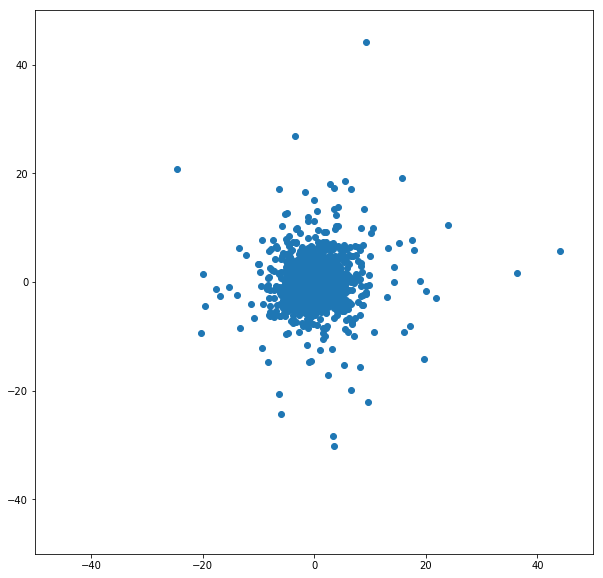

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(*x[[0,1],:])
lim = 50
plt.xlim(-lim,lim)
plt.ylim(-lim,lim)

In [6]:
axes = [0,1]

In [7]:
def find_closest_naive():
    diff = x[axes,np.newaxis,:10000] - x[axes,10000:,np.newaxis]
    sort = np.argsort(diff, axis = 1)
    
    return sort[:,:,0]

In [8]:
find_closest_naive()

array([[1217, 6715, 2202, ..., 2381, 1523,   65],
       [  65, 8834, 1523, ..., 4036, 1994, 4967]], dtype=int64)

In [9]:
%timeit find_closest_naive()

12.9 s ± 49.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
def find_closest_digitize():
    ffp = m < 1e-3
    stars = m > 1e-3

    bins1, bins2 = np.linspace(min(x[axes[0]]), max(x[axes[0]]), 300), np.linspace(min(x[axes[1]]), max(x[axes[1]]), 300)
    i_stars, j_stars = np.digitize(x[axes[0]][stars], bins1), np.digitize(x[axes[1]][stars], bins2)
    
    events = []
    
    for ffp_num in np.arange(len(m))[ffp]:
        i_ffp, j_ffp = np.digitize(x[axes[0]][ffp_num], bins1), np.digitize(x[axes[1]][ffp_num], bins2)
        
        vicinity = [-1,0,1]
        neighbours = np.logical_and(np.isin(i_stars, i_ffp + vicinity), np.isin(j_stars, j_ffp + vicinity))
        
        distances = np.linalg.norm(x[axes][:,stars][:,neighbours] - x[axes,ffp_num][:,np.newaxis], axis = 0)
        lensed = distances < 0.05
        
        for i in np.arange(len(m))[stars][neighbours][lensed]:
            events.append(i)
    
    return np.array(events)

In [11]:
find_closest_digitize()

array([ 327, 4793, 4892, ..., 2733, 3030, 7006])

In [12]:
%timeit find_closest_digitize()

3.83 s ± 191 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
from scipy.spatial import KDTree

def find_closest_kdtree():
    tree = KDTree(x[axes,:10000].T, leafsize=50)
    
    neighbours = tree.query_ball_point(x[axes,10000:].T, 0.05)
    
    return neighbours

In [14]:
find_closest_kdtree()

array([list([291]), list([]), list([1056, 842, 6588, 6672]), ...,
       list([7966, 7772, 3249, 2042, 2521, 5749, 2187]),
       list([2251, 2725, 4417, 1024, 9889]),
       list([9082, 8891, 4327, 5650, 9360, 6690, 2903, 8567, 9018, 9821, 8205, 3469, 3910, 661, 1717, 4025, 1852, 3030, 7006, 3065, 3545, 4966, 9656, 650, 9995, 9202, 9539, 3832, 6341, 8575])],
      dtype=object)

In [15]:
%timeit find_closest_kdtree()

19.1 s ± 323 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit find_closest_kdtree()

9.32 s ± 57.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
